# Data Loading and Processing Tutorial

In [5]:
import os
import torch
import pandas as pd
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.ion()            # interactive mode

In [6]:
# read CSV and get annotations in (N,2) array where N is the number of landmarks
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


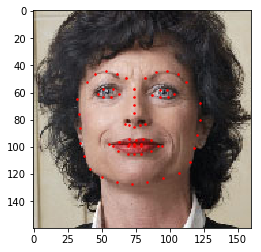

In [7]:
# simple helper function to show an image and its landmarks
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)      # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
              landmarks)
plt.show()

## Dataset class

```torch.utils.data.Dataset``` - abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:
1. ```__len__``` so that len(dataset) returns the size of the dataset
2. ```__getitem__``` to support indexing such that dataset[i] can be used to get ith sample

Let's create a dataset class for our face landmarks dataset. We will read the csv in ```__init__``` but leave reading of images to ```__getitem__``` (memory efficient).

Sample of our dataset will be a dict ```{'image': image, 'landmarks': landmarks}```. Our dataset will take an optional arg ```transform``` so that any required processing can be applied on the sample.

In [8]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
    
        if self.transform:
            sample = self.transform(sample)
        
        return sample

0 (324, 215, 3) (68, 2)


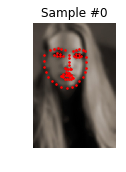

1 (500, 333, 3) (68, 2)


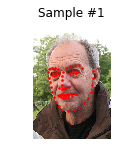

2 (250, 258, 3) (68, 2)


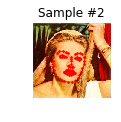

3 (434, 290, 3) (68, 2)


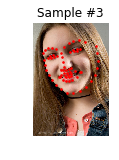

In [9]:
# instantiate this class and iterate through the data samples
# print sizes of first 4 samples and show their landmarks

face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

## Transforms

One issue from above: samples are not the same size. Most neural nets expect images of a fixed size. So, let's create three transforms:
1. ```Rescale```: to scale the image
2. ```RandomCrop```: to crop from image randomly (data augmentation)
3. ```ToTensor```: convert numpy images to torch images (need to swap axes)

We'll write them as callable classes instead of simple functions so that parameters of the transform don't have to be passed everytime it's called. Just need to implement ```__call__``` and if required, ```__init__```. Then, can use a transform like this:

```tsfm = Transform(params)
transformed_sample = tsfm(sample)```

Transforms have to be applied both on image and landmarks.

In [11]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': img, 'landmarks': landmarks}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.
    
    Args:
        output_size (tuple or int): Desired output size. If int, square rop
            is made.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h,
                      left: left + new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose transforms

Apply transforms on a sample. Rescale the shorter side of the image to 256 and then randomly crop a square size 224 from it (we want to compose ```Rescale``` and ```RandomCrop``` transforms). ```torchvision.transforms.Compose``` is a simple callable class which allows us to do this.

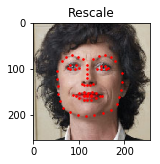

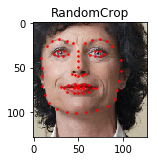

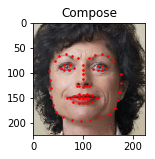

In [12]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Iterating through the dataset

Let's put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:
  1. an image is read from file on the fly
  2. Transforms are applied on the read image
  3. Since one of the transforms is random, data is augmented on sampling
  
We can iterate over created dataset with a ```for i in range``` loop as before.

In [13]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


We are losing a lot of features by using a simple ```for``` loop to iterate. Missing out on:
  - batching the data
  - shuffling the data
  - load the data in parallel using ```multiprocessing``` workers.
  
```torch.utils.data.DataLoader``` is an iterator which provides all these features. One parameter of interest: ```collate_fn```. Can specify how exactly samples need to be batched using ```collate_fn``` (default collate should work in most use cases).

Also, look at ```torchvision``` package for some common datasets and transforms. Generic transforms can operate on ```PIL.Image``` like ```RandomHorizontalFlip```, ```Scale```, etc.

In [ ]:
# can write data transform like this
from torchvision import datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)